In [1]:
from __future__ import division
import argparse
import math
import sys, site, os
import matplotlib.pyplot as plt

# site.addsitedir('/afs/ece.cmu.edu/usr/reletreb/dep/lib/python2.7/site-packages')


import numpy as np
from scipy.optimize import fsolve
from scipy.special import comb
from scipy.stats import poisson
import scipy.optimize
import scipy.misc

numNodes = 100000;
rho = 1.0/numNodes

max_degree = 20  #### 1. I am using 22, I stop when the p(degree) < 1/node_num ####

def obtain_val_r_1(v1, v2, t1, lambda_r):
    val = 0

    for d_r in range(0, max_degree):
        if d_r == 0: continue

        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val = 0

        for k1 in range(0, d_r):
            for k2 in range(0, d_r - k1):
                if k1 == 0 and k2 == 0: continue

                extra_term = 0

                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term += comb(k1, x) * comb(k2, y) * t1**x * t2**y *\
                        (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_11+y*u_r_21)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val += comb(d_r - 1, k1) * comb(d_r - 1 - k1, k2) *(v1**k1) * (v2 ** k2) * \
                ((1 - v1 - v2) ** (d_r - 1 - k1 - k2)) *\
                (a2*(1-a1)*u_r_11 + a1*(1-a2)*u_r_21  + extra_term )

        val += d_r*prob_r*1.0/lambda_r * tmp_val

    return rho + (1 - rho)*val  #### 2. Why need to this? Shouldn't return val as q_{l + 1, i}? #### 
                                #=> rho: frac of seeds

def obtain_val_r_2(v1, v2, t2, lambda_r):
    val = 0

    for d_r in range(0, max_degree):
        if d_r == 0: continue
        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val = 0


        for k1 in range(0, d_r):
            for k2 in range(0, d_r - k1):
                if k1 == 0 and k2 == 0: continue

                extra_term = 0

                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term += comb(k1, x) * comb(k2, y) * t1**x * \
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_12+y*u_r_22)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val += comb(d_r - 1, k1) * comb(d_r - 1 - k1, k2) *(v1**k1) * (v2 ** k2) * \
                ((1 - v1 - v2) ** (d_r - 1 - k1 - k2)) *\
                (a2*(1-a1)*u_r_12 + a1*(1-a2)*u_r_22  + extra_term )

        val += d_r*prob_r*1.0/lambda_r * tmp_val

    return rho + (1 - rho)*val #### 2. Why need to this? Shouldn't return val as q_{l + 1, i}? #### 

def equations(p):
    v1, v2 = p
    val_r_1 = obtain_val_r_1(v1, v2, t1, lambda_r)
    val_r_2 = obtain_val_r_2(v1, v2, t2, lambda_r)

    return (v1 - val_r_1, v2 - val_r_2) 


def cascade_size(lambda_r):
    
    # 3. 
    # To be confirmed: h_r_1, h_r_2 are prob of Emergence?
    h_r_1, h_r_2 = fsolve(equations, (0.9, 0.9), xtol=1e-10) # Get roots q1 and q2

    H = 0
    H1 = 0
    H2 = 0
    
    # 4. Cascade size(infection frac)
    # Rashad: Doing one more iteration of infection
    # Yurun: start from [0.1, 0.1], then keep the iterations to the level of inf
    
    # 5. To be confrimed: cascade size here is infection frac or epidemic size? 
    
    for d_r in range(0, max_degree): 
        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val1 = 0
        tmp_val2 = 0

        for k1 in range(0, d_r + 1):
            for k2 in range(0, d_r + 1 - k1):
                extra_term_1 = 0
                extra_term_2 = 0
                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term_1 += comb(k1, x) * comb(k2, y) * t1**x *\
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_11+y*u_r_21)/(x+y))
                        extra_term_2 += comb(k1, x) * comb(k2, y) * t1**x *\
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_12+y*u_r_22)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val1 += comb(d_r , k1) * comb(d_r - k1, k2) *(h_r_1**k1) * (h_r_2 ** k2) * \
                ((1 - h_r_1 - h_r_2) ** (d_r - k1 - k2)) *\
                (a2*(1-a1)*u_r_11 + a1*(1-a2)*u_r_21  + extra_term_1 )

                tmp_val2 += comb(d_r, k1) * comb(d_r - k1, k2) *(h_r_1**k1) * (h_r_2 ** k2) * \
                ((1 - h_r_1 - h_r_2) ** (d_r - k1 - k2)) *\
                (a2*(1-a1)*u_r_12 + a1*(1-a2)*u_r_22  + extra_term_2 )

        H += prob_r * (tmp_val1 + tmp_val2) 
        H1 += prob_r * tmp_val1
        H2 += prob_r * tmp_val2

    return (lambda_r, H, H1, H2, h_r_1, h_r_2)

def parse_args(args):
    parser = argparse.ArgumentParser(description = 'Parameters')
    parser.add_argument('-m', type = float, nargs = '+', default = np.arange(0.1, 10.1, 0.1), \
    help='np.linspace(0.001, 12, 100) (default); list of mean degree: you can type 1 3 5')
    parser.add_argument('-t1', type = float, default = 0.044, \
     help='0.5 (default); the transmissibility of strain-1')
    parser.add_argument('-t2', type = float, default = 0.12, \
    help='0.5 (default); the transmissibility of strain-2')
    parser.add_argument('-m1', type = float, default = 0.75, \
    help='0.5 (default); the mutation probability from 1 to 1')
    parser.add_argument('-m2', type = float, default = 0.75, \
    help='0.5 (default); the mutation probability from 2 to 2')
    return parser.parse_args(args)

# paras = parse_args(sys.argv[1:])
# t1 = paras.t1
# t2 = paras.t2
# m1 = paras.m1
# m2 = paras.m2
# mean_degree_list = paras.m

t1 = 0.10800
t2 = 0.20400
m1 = 0.66667
m2 = 0.47059
mean_degree_list = np.linspace(0, 10, 50)

infection_size = []
infection_size0 = []
infection_size1 = []


for lambda_r in mean_degree_list:
    u_r_11 = m1
    u_r_12 = 1-u_r_11
    u_r_22 = m2
    u_r_21 = 1-u_r_22
    
    lambda_r, H, H1, H2, h_r_1, h_r_2 = cascade_size(lambda_r)
    infection_size.append(H) 
    infection_size0.append(H1)
    infection_size1.append(H2)


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Theoratical Infection Fraction for Mutation Model')

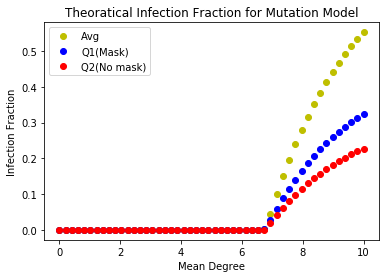

In [3]:
plt.figure()
plt.plot(mean_degree_list, infection_size, 'yo')
plt.plot(mean_degree_list, infection_size0, 'bo')
plt.plot(mean_degree_list, infection_size1, 'ro')

plt.legend(["Avg", "Q1(Mask)", "Q2(No mask)"])
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Theoratical Infection Fraction for Mutation Model"
plt.title(title)